#Client Advertiser ALI Identification Tool

The aim of this notebook is to run an analysis on a client's existing campaigns, to identify potential advertiser candidates that we can recommend testing of and migration to Augmented Line Items.

Steps to run:

1. Input the member ID in the below cell

2. Select "Run All" from the Cell dropdown in the header

Any questions or suggestions please ask Anne or Cyril

In [168]:
member_id = 668

scope = 14 # days
limit = 5 # Number of items displayed

In [169]:
from link import lnk
import pandas as pd
import sys
import datetime
from dateutil.relativedelta import relativedelta
reload(sys)
sys.setdefaultencoding('utf8')
import os
import numpy as np
import time
from IPython.display import HTML

pd.set_option('display.max_colwidth', -1)

In [170]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [171]:
def df_to_list(dataframe_column):
    # change a dataframe column to a list wrapped in parentheses
    # (to input in SQL, Vertica queries)
    result = "(-2)"
    if len(dataframe_column) > 0:
        result = ", ".join(map(str, list(set(dataframe_column))))
        result = "(" + result + ")"
    return result

##Quick check of proportion of active, non-deleted insertion orders which are seamless

,io_type,count
0,Legacy,1857
1,Seamless,2591


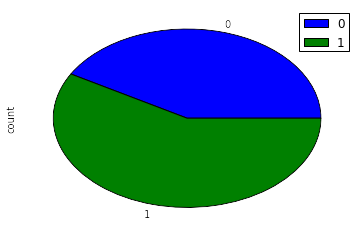

In [199]:
def seamless_info(member_id):
	SQL = """select (case when budget_allocation_required = 1 then "Seamless" else "Legacy" end) as io_type, 
        count(id) as count 
        from bidder.insertion_order
        where member_id in ('%s')
        and state='active' 
        and deleted=0 group by 1;;""" % (str(member_id))
	df = lnk.dbs.mysql_prod_api.select(SQL).as_dataframe()
	return df
seamless = seamless_info(member_id)
import matplotlib.pyplot as plt
%matplotlib inline
seamless.plot(kind='pie',x='io_type', y='count')
seamless

Note: Next steps for this section - add a pie chart

##1. Campaigns under seamless IOs or no IO

###1. a) Optimising to CPC goal

In [173]:
def get_ios(member_id,budget_allocation):
    SQL = """select io.id as insertion_order_id
        from bidder.insertion_order io
        where io.member_id in ('%s')
        and io.state = 'active'
        and io.budget_allocation_required = %d
        and io.deleted=0 
        order by 1 desc;""" % (str(member_id),budget_allocation)
    df = lnk.dbs.mysql_prod_api.select(SQL).as_dataframe()
    seamless_ios = df_to_list(df['insertion_order_id'])
    return seamless_ios

def get_opt_to_cpc_campaigns(member_id, member_ios):
    SQL = """SELECT c.id as campaign_id, c.name as campaign_name, c.advertiser_id, a.name as advertiser_name
        FROM bidder.campaign c
        JOIN bidder.insertion_order_campaign_group iocg ON c.campaign_group_id = iocg.campaign_group_id
        JOIN bidder.advertiser a ON c.advertiser_id=a.id
        WHERE c.member_id in ('%s')
        AND (iocg.insertion_order_id in %s OR a.use_insertion_orders = 0)
        AND c.deleted=0
        AND c.state = 'active'
        AND c.cpc_goal IS NOT NULL
        GROUP BY 1;""" % (str(member_id), member_seamless_ios)
    df_opt_to_cpc_camps = lnk.dbs.mysql_prod_api.select(SQL).as_dataframe()
    return df_opt_to_cpc_camps
    
def get_revenue_from_df_campaigns(campaign_or_campaign_group, df_campaigns):
    campaign_list = df_to_list(df_campaigns['%s_id' % campaign_or_campaign_group])
    
    VSQL = """SELECT %s_id,
        sum(media_cost_dollars) as media_cost_%s_days
        FROM agg_dw_advertiser_publisher_analytics_adjusted 
        WHERE %s_id IN %s
        AND ymdh >= now() - interval '%s days'
        GROUP BY 1
        ORDER BY 2 DESC;""" % (campaign_or_campaign_group, scope, campaign_or_campaign_group, campaign_list, scope)
    df_revenue = lnk.dbs.vertica.select(VSQL).as_dataframe()
    
    df = pd.merge(df_revenue, df_campaigns, how='left', on='%s_id' % campaign_or_campaign_group)

    if df.empty:
        print "There are no campaigns in this category for this member."
    return df

   
member_seamless_ios = get_ios(member_id,1)
df_opt_to_cpc_campaigns = get_opt_to_cpc_campaigns(member_id, member_seamless_ios)
df_opt_to_cpc_campaigns_revenue = get_revenue_from_df_campaigns('campaign', df_opt_to_cpc_campaigns)
advertiser_opt_to_cpc = df_opt_to_cpc_campaigns_revenue.groupby(by=['advertiser_name',
                                                  'advertiser_id']).agg({'campaign_id':'count', 
                                                                         'media_cost_14_days': 'sum'}).sort('media_cost_14_days',
                                                                                                            ascending=False)


####Top Advertisers spend on CPC campaigns

In [174]:
advertiser_opt_to_cpc.head(limit)

,,media_cost_14_days,campaign_id
advertiser_name,advertiser_id,,
DIRECTV c/o iCrossing NY,1105469,9563.889978,19
Bridgestone Golf Inc. c/o GKV,1533008,5412.589899,11
Hologic c/o Pathfinder,963221,5350.214803,61
Century Link c/o Mullen Lowe NC,1461985,3187.027877,17
Land O' Lakes c/o The Martin Agency,1298227,2699.492188,7


####Top CPC Campaigns 

In [175]:
df_opt_to_cpc_campaigns_revenue.head(limit)

,campaign_id,media_cost_14_days,campaign_name,advertiser_id,advertiser_name
0,15756284,3710.127100,Bridgestone Golf - Native - Reach - Broad,1533008,Bridgestone Golf Inc. c/o GKV
1,16414829,3673.759030,Copy DirecTV - Prospecting - 2017 - CTR Temp,1105469,DIRECTV c/o iCrossing NY
2,16414831,2178.921723,Copy DirecTV - Prospecting - 2017 - Placement Whitelist,1105469,DIRECTV c/o iCrossing NY
3,16297593,1455.508522,NCIRD Children's Campaign - High CTR Placements - CPC Optimized,1680675,NCIRD c/o Porter Novelli
4,16414832,1427.699857,Copy DirecTV - Prospecting - 2017 - Top CTR Pubs,1105469,DIRECTV c/o iCrossing NY


###1. b) With name like viewability

In [176]:
def get_campaign_with_viewability_name(member_id, member_seamless_ios):
    SQL = """SELECT c.id as campaign_id, c.name as campaign_name,  c.advertiser_id, a.name as advertiser_name
        FROM bidder.campaign c
        JOIN bidder.advertiser a ON c.advertiser_id = a.id
        JOIN bidder.insertion_order_campaign_group iocg ON c.campaign_group_id = iocg.campaign_group_id
        WHERE c.member_id in ('%s')
        AND c.deleted=0
        AND (iocg.insertion_order_id in %s OR a.use_insertion_orders = 0)
        AND c.state = 'active'
        AND (LOWER(c.name) LIKE '%%iewability%%' OR LOWER(c.name) LIKE '%%isibili%%' OR LOWER(c.name) LIKE '%%vcpm%%' OR LOWER(c.name) LIKE '%%cpvm%%')
        GROUP BY 1,2,3;""" % (str(member_id), member_seamless_ios)
    df_campaigns_with_viewability_name = lnk.dbs.mysql_prod_api.select(SQL).as_dataframe()
    return df_campaigns_with_viewability_name


df_campaigns_with_viewability_name = get_campaign_with_viewability_name(member_id, member_seamless_ios)
df_campaigns_with_viewability_name_revenue = get_revenue_from_df_campaigns('campaign', df_campaigns_with_viewability_name)
advertiser_viewability = df_campaigns_with_viewability_name_revenue.groupby(by=['advertiser_name',
                                                  'advertiser_id']).agg({'campaign_id':'count', 
                                                                         'media_cost_14_days': 'sum'}).sort('media_cost_14_days',
                                                                                                            ascending=False)



####Top Advertiser spend on viewability campaigns

In [177]:
advertiser_viewability.head(limit)

,,media_cost_14_days,campaign_id
advertiser_name,advertiser_id,,
DIRECTV c/o iCrossing NY,1105469,16399.449119,8
Avis & Budget Group North America c/o House of Kaizen NY,287750,12930.684025,9
Barclaycard c/o Mullen Lowe,775664,11277.582755,4
Just Eat c/o M/Six,995298,7576.713499,35
Mattress Firm c/o Merkle Inc,1355016,3771.208653,11


#### Top viewability campaigns

In [178]:
df_campaigns_with_viewability_name_revenue.head(limit)

,campaign_id,media_cost_14_days,campaign_name,advertiser_id,advertiser_name
0,16284572,6832.177602,DirecTV - Prospecting - 2017 - Non-Google High Viewability Placements,1105469,DIRECTV c/o iCrossing NY
1,15362778,5992.282255,Barclaycard - JetBlue - Prospecting - 2017 - RTB - 1.5 - Viewability - Free - outlook.com,775664,Barclaycard c/o Mullen Lowe
2,15769750,4196.511664,DirecTV - Prospecting - 2017 - KWs - Non-NFL Sports + Viewability - Context+Audience (7729809/10),1105469,DIRECTV c/o iCrossing NY
3,15965673,3835.022044,DirecTV - Prospecting - 2017 - KWs - Non-NFL Sports + Viewability - Context+Audience (7729809/10),1105469,DIRECTV c/o iCrossing NY
4,15403166,3416.978694,US - Avis - Prospecting -1 - Reach - 1.2 - Viewability Tree,287750,Avis & Budget Group North America c/o House of Kaizen NY


In [179]:
###1. c) Bidding EAP, ECP, CPC or CPA

In [180]:
def get_ecp_eap_campaigns(member_id, member_seamless_ios):
    SQL = """SELECT c.id as campaign_id, c.name as campaign_name,  c.advertiser_id, a.name as advertiser_name, cpm_bid_type
        FROM bidder.campaign c
        JOIN bidder.advertiser a ON c.advertiser_id = a.id
        JOIN bidder.insertion_order_campaign_group iocg ON c.campaign_group_id = iocg.campaign_group_id
        WHERE c.member_id in ('%s')
        AND c.deleted=0
        AND (iocg.insertion_order_id in %s OR a.use_insertion_orders = 0)
        AND cpm_bid_type IN ('average', 'clearing')
        AND c.state = 'active'
        GROUP BY 1,2,3;""" % (str(member_id), member_seamless_ios)
    df_ecp_eap_campaigns = lnk.dbs.mysql_prod_api.select(SQL).as_dataframe()
    return df_ecp_eap_campaigns

df_ecp_eap_campaigns = get_ecp_eap_campaigns(member_id, member_seamless_ios)
df_ecp_eap_campaigns
df_ecp_eap_campaigns_revenue = get_revenue_from_df_campaigns('campaign', df_ecp_eap_campaigns)
advertiser_ecp_eap = df_ecp_eap_campaigns_revenue.groupby(by=['advertiser_name',
                                                  'advertiser_id']).agg({'campaign_id':'count', 
                                                                         'media_cost_14_days': 'sum'}).sort('media_cost_14_days',
                                                                                                            ascending=False)

### 1. c) EAC and ECP campaigns

####Top Advertiser spend on EAP and ECP campaigns

In [181]:
advertiser_ecp_eap.head(limit)

,,media_cost_14_days,campaign_id
advertiser_name,advertiser_id,,
Paperworld c/o In Front Media - Trade Indy,499300,167.761564,1
eBay.de c/o Mediacom DE,494863,109.669242,2
The Chia Co c/o InFront Media - EMS - Trade Indy,1212641,2.116392,1
Skoda c/o FCB New Zealand,1426328,0.000000,1


####Top EAP and ECP campaigns

In [182]:
df_ecp_eap_campaigns_revenue.head(limit)

,campaign_id,media_cost_14_days,campaign_name,advertiser_id,advertiser_name,cpm_bid_type
0,14043590,167.761564,Paperworld - Prospecting - Context - PD - Overlap Domains - EAP,499300,Paperworld c/o In Front Media - Trade Indy,average
1,16206755,56.406080,ebay UK - BAU - Evergreen - desktop - Historical Performing Domains - EAP,494863,eBay.de c/o Mediacom DE,average
2,16133533,53.263162,ebay DE - Set 1 - BYOA - Interested Users - Domain List - Manual CPM,494863,eBay.de c/o Mediacom DE,average
3,14573050,2.116392,The Chia Co - Prospecting - Context - Client Domains - EAP,1212641,The Chia Co c/o InFront Media - EMS - Trade Indy,average
4,15820381,0.000000,Skoda - Prospecting - Context - Overlap Domains Low Vol - ECP,1426328,Skoda c/o FCB New Zealand,clearing


###1. d) Buying on a CPC or CPA

In [183]:
def get_cpc_cpa_campaigns(member_id, member_seamless_ios):
    SQL = """SELECT c.id as campaign_id, c.name as campaign_name,  c.advertiser_id, a.name as advertiser_name, cpm_bid_type
        FROM bidder.campaign c
        JOIN bidder.advertiser a ON c.advertiser_id = a.id
        JOIN bidder.insertion_order_campaign_group iocg ON c.campaign_group_id = iocg.campaign_group_id
        WHERE c.member_id in ('%s')
        AND c.deleted=0
        AND (iocg.insertion_order_id in %s OR a.use_insertion_orders = 0)
        AND cpm_bid_type IN ('none')
        AND c.state = 'active'
        GROUP BY 1,2,3;""" % (str(member_id), member_seamless_ios)
    df_ecp_eap_campaigns = lnk.dbs.mysql_prod_api.select(SQL).as_dataframe()
    return df_ecp_eap_campaigns

df_cpc_cpa_campaigns = get_cpc_cpa_campaigns(member_id, member_seamless_ios)
df_cpc_cpa_campaigns
df_cpc_cpa_campaigns_revenue = get_revenue_from_df_campaigns('campaign', df_cpc_cpa_campaigns)
advertiser_cpc_cpa = df_cpc_cpa_campaigns_revenue.groupby(by=['advertiser_name',
                                                  'advertiser_id']).agg({'campaign_id':'count', 
                                                                         'media_cost_14_days': 'sum'}).sort('media_cost_14_days',
                                                                                                            ascending=False)

####Top Advertiser spend on campaigns buying on a CPC or CPA

In [184]:
advertiser_cpc_cpa.head(limit)

,,media_cost_14_days,campaign_id
advertiser_name,advertiser_id,,
DIRECTV c/o iCrossing NY,1105469,95.25,6


####Top Campaigns buying on a CPC or CPA

In [185]:
df_cpc_cpa_campaigns_revenue.head(limit)

,campaign_id,media_cost_14_days,campaign_name,advertiser_id,advertiser_name,cpm_bid_type
0,16414833,75.00,Copy DirecTV - Prospecting - 2017 - CPC,1105469,DIRECTV c/o iCrossing NY,none
1,16539026,11.25,Copy Copy DirecTV - Prospecting - 2017 - CPC,1105469,DIRECTV c/o iCrossing NY,none
2,16539132,8.25,Copy Copy DirecTV - Prospecting - 2017 - CPC,1105469,DIRECTV c/o iCrossing NY,none
3,16539142,0.75,Copy 75k+ DirecTV - Prospecting - 2017 - CPC,1105469,DIRECTV c/o iCrossing NY,none
4,16538833,0.00,75k+ DirecTV - Prospecting - 2017 - CPC,1105469,DIRECTV c/o iCrossing NY,none


##2. Campaigns under legacy IO

###2. a) Optimising to CPC goal

In [186]:
member_legacy_ios = get_ios(member_id,0)
df_opt_to_cpc_campaigns = get_opt_to_cpc_campaigns(member_id, member_legacy_ios)
df_opt_to_cpc_campaigns_revenue = get_revenue_from_df_campaigns('campaign', df_opt_to_cpc_campaigns)
advertiser_opt_to_cpc_legacy = df_opt_to_cpc_campaigns_revenue.groupby(by=['advertiser_name',
                                                  'advertiser_id']).agg({'campaign_id':'count', 
                                                                         'media_cost_14_days': 'sum'}).sort('media_cost_14_days',
                                                                                                            ascending=False)
advertiser_opt_to_cpc_legacy.head(limit)

,,media_cost_14_days,campaign_id
advertiser_name,advertiser_id,,
DIRECTV c/o iCrossing NY,1105469,9563.889978,19
Bridgestone Golf Inc. c/o GKV,1533008,5412.589899,11
Hologic c/o Pathfinder,963221,5350.214803,61
Century Link c/o Mullen Lowe NC,1461985,3187.027877,17
Land O' Lakes c/o The Martin Agency,1298227,2699.492188,7


###2. b) With name like viewability

In [187]:
df_leg_campaigns_with_viewability_name = get_campaign_with_viewability_name(member_id, member_legacy_ios)
df_leg_campaigns_with_viewability_name_revenue = get_revenue_from_df_campaigns('campaign', df_leg_campaigns_with_viewability_name)
advertiser_viewability_leg = df_leg_campaigns_with_viewability_name_revenue.groupby(by=['advertiser_name',
                                                  'advertiser_id']).agg({'campaign_id':'count', 
                                                                         'media_cost_14_days': 'sum'}).sort('media_cost_14_days',
                                                                                                            ascending=False)

In [188]:
df_leg_campaigns_with_viewability_name_revenue.head(limit)

,campaign_id,media_cost_14_days,campaign_name,advertiser_id,advertiser_name
0,15443908,1268.939159,AMEX - Prospecting - Reach - PD - Seller Whitelist (DPI) - APB Viewability Tree,282921,AMEX c/o Mindshare UK
1,16115184,1079.406727,Human Appeal - Qurbani - Prospecting - Reach - AS - Whitelist - APB Viewability,510181,Human Appeal c/o Republic of Media
2,14235625,864.389624,Vitality Health - Prospecting - New 2016 Site - Reach - High Viewability - APB {15409},271854,Vitality c/o mSIX
3,12030877,756.033133,Bayer - Brand - Reach - Pets - High Viewability - Custom APB Model,790000,Bayer c/o Mediacom
4,15884232,371.246326,Bayer - Brand - Reach - Viewability - Top Domain Group - Manual CPM,790000,Bayer c/o Mediacom


In [189]:
###Post click conversions

In [190]:
#Member level: % post click conversions / all conversions
#    select sum(post_view_convs)/(sum(post_view_convs)+sum(post_click_convs)),sum(post_click_convs)/(sum(post_view_convs)+sum(post_click_convs))
#from agg_dw_advertiser_publisher_analytics_adjusted
#where member_id=1311
#and ymdh >= now() - interval '30 days';

###Next Steps and Thoughts

1. Proportion of total spend on each criteria (CPC opt, etc.) will be useful analysis for internal planning
2. What is the cost (our time) / benefit of looking at features used in APB trees.
3. We could add the ALI traction graph from snapshots here, so we can track adoption against these kpis - i.e. we should see the number of the campaigns we identify go down over time
4. Campaign bidding fixed CPM could be a good fit for ALI
5. Adding Post click CPA
6. Adding line items that have a single active campaign
7. Make it more descriptive for AMs to be able to use it (clarify why we included each section, etc.)
8. Adding Standard Line Items that are using viewability thresholds

Change Log
- Added support for advertisers that don't use IOs at all
- Rearranged the different cells - first all Seamless & no IO, then all legacy IO